In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchvision import datasets, transforms
import torchvision.transforms.functional as F
from torchvision.utils import make_grid

import os
import random
import numpy as np
import matplotlib.pyplot as plt

from math import ceil
from tqdm import tqdm
from PIL import Image

In [2]:
# Set manual seeds for reproducibility
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

#torch.use_deterministic_algorithms(True)

In [3]:
# Constants 
dataset_path = "../Dataset"
models_path  = "../models"
BATCH_SIZE = 512

if torch.cuda.is_available():
  _DEVICE = "cuda"
else:
  _DEVICE = "cpu"

In [4]:
# Helper functions
def count_parameters(NN):
    return sum([p.numel() for p in NN.parameters() if p.requires_grad==True])

def get_one_hot_encoder(labels):
    def ohe(target):
        oh_vec=torch.zeros(len(labels), dtype=torch.float)
        oh_vec[target] = 1.
        return oh_vec
    return ohe

In [5]:
# Dataset loader
transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
transform_denorm = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor()])
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

dataset_raw = datasets.ImageFolder(f'{dataset_path}/Train', transform=transform_denorm)
dataset = datasets.ImageFolder(f'{dataset_path}/Train', transform=transform, target_transform=get_one_hot_encoder(dataset_raw.classes))

dataset_train, dataset_val = torch.utils.data.random_split(dataset, [int(len(dataset)*0.8), 
                                                                      ceil(len(dataset)*0.2)])

dataset_test  = datasets.ImageFolder(f'{dataset_path}/Test', transform=transform)

train_loader = data.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = data.DataLoader(dataset_test,  batch_size=BATCH_SIZE, shuffle=True)
val_loader   = data.DataLoader(dataset_val,   batch_size=BATCH_SIZE, shuffle=True)

dataset_raw_val = [dataset_raw[d] for d in dataset_val.indices]
val_raw_loader  = data.DataLoader(dataset_raw_val,  batch_size=BATCH_SIZE, shuffle=True)

In [6]:
trainSteps = len(train_loader.dataset) // BATCH_SIZE
valSteps   = len(val_loader.dataset)  // BATCH_SIZE

In [7]:
# loading icons for signs
img_names = os.listdir(f"{dataset_path}/Vzor")
icons = dict()

for idx, name in enumerate(img_names):
    img_name = f"{dataset_path}/Vzor/{name}"
    image = Image.open(img_name)
    icons[name.split('.')[0]] = image.resize((224,224), Image.LANCZOS)

icons = np.stack([icons[k] for k in dataset.class_to_idx.keys()], axis=0)

In [8]:
# Load pretrained AlexNet
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model.eval()

# Feezing parameters
for param in model.parameters():
    param.requires_grad = False

Using cache found in /home/nzuri/.cache/torch/hub/pytorch_vision_v0.10.0
/home/nzuri/Documents/Projects/HNS_Znacky_Zadanie1/.venv/lib64/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nzuri/Documents/Projects/HNS_Znacky_Zadanie1/.venv/lib64/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
model.classifier = nn.Sequential(
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=9216, out_features=256, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=256, out_features=256, bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=256, out_features=len(dataset.classes), bias=True)
)

In [10]:
print(f"trainable parameters: {count_parameters(model)}")

trainable parameters: 2428428


In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
model.load_state_dict(torch.load(f"{models_path}/v1.pt", weights_only=True))

<All keys matched successfully>

In [ ]:
N_EPOCH = 100

model.to(_DEVICE)
progress_bar = tqdm(range(0, N_EPOCH))
H = {"train_loss": [],	  "val_loss": []}
for epoch in progress_bar:
    totalTrainLoss = 0
    totalValLoss = 0
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        inputs = inputs.to(_DEVICE)
        outputs = model(inputs)
        targets = targets.to(torch.float32).to(_DEVICE)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        totalTrainLoss += loss

    with torch.no_grad():
      model.eval()
      for inputs, targets in val_loader:
        inputs = inputs.to(_DEVICE)
        outputs = model(inputs)
        targets = targets.to(_DEVICE)
        totalValLoss += loss_fn(outputs, targets)

    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss   = totalValLoss / valSteps
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["val_loss"].append(avgValLoss.cpu().detach().numpy())
    progress_bar.set_description(f"Train loss: {avgTrainLoss:.6f} | Val loss: {avgValLoss:.6f}")

In [14]:
torch.save(model.state_dict(), f"{models_path}/v1.pt")

In [13]:
def predict_all(loader, transform=lambda x: x):
    predictions = list()
    model.to(_DEVICE)
    model.eval()
    with torch.no_grad():
        for _inputs, _ in tqdm(loader):
            _inputs = _inputs.to(_DEVICE)
            inputs = transform(_inputs)
            outputs = model(inputs)
            predictions.append(
                [_inputs.cpu().detach(), outputs.cpu().detach()]
            )
    return torch.cat([p[0] for p in predictions]), \
           torch.cat([p[1] for p in predictions])

In [38]:
def show_predictions(predictions, N, rand=True):
    if rand:
        selector = np.random.choice(range(0,len(predictions[0])), N)
    else:
        selector = list(range(0,N))
        
    source, est = predictions
    source = source[selector]
    est = est[selector]
    fig, axs = plt.subplots(N, 3)
    for i, (s_img, prob) in enumerate(zip(source, est)):
        axs[i, 0].imshow(F.to_pil_image(s_img))
        axs[i, 0].axis("off")
        
        prob_norm = torch.nn.functional.softmax(prob, dim=0).cpu()
        
        idx = np.argmax(prob_norm)
        axs[i, 1].imshow(icons[idx])
        axs[i, 1].axis("off")

        axs[i, 2].bar(dataset.class_to_idx.values(), prob_norm)
        axs[i, 2].axis("on")

    #fig.tight_layout() 
    fig.subplots_adjust(hspace=0.15, wspace=0)
        
    return fig, axs

In [15]:
predictions = predict_all(val_raw_loader, transform=normalize)

100%|██████████| 6/6 [00:02<00:00,  2.49it/s]


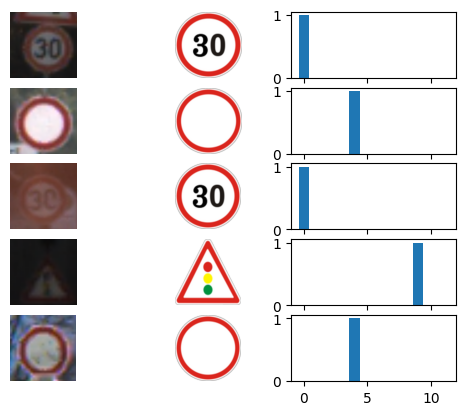

In [39]:
_ = show_predictions(predictions, 5)